In [2]:
%load_ext autoreload
%autoreload 2
from utils.load import *
from utils.visualisation import *
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# cfg_file = "config.yaml"

# config = read_config(cfg_file)


Load Radar Dataset

In [4]:
from utils.load import load_radar_dataset

radar_df = load_radar_dataset(folder_name='sg_radar_data')

print(radar_df)

The size of dataset is 8334
                time_sgt                                               data  \
0    2025-03-30 21:30:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1    2025-03-30 09:15:00  [[19.946491, 23.97211, 22.529737, 22.059525, 2...   
2    2025-03-30 18:30:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3    2025-03-30 22:45:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4    2025-03-30 08:45:00  [[0.0, 0.029074356, 0.079635546, 0.082681194, ...   
...                  ...                                                ...   
8329 2025-03-16 22:30:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8330 2025-03-16 18:45:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8331 2025-03-16 20:15:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8332 2025-03-16 08:30:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8333 2025-03-16 19:15:00  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                       

In [5]:
#cml_df = load_cml_dataset(dataset_name="CML_data_processed_2025.nc")
# gauge_df = load_raingauge_dataset(dataset_name='station_locations.csv')

Load raingauge dataset

Filter formatted gauge dataframe to only include if at least N sensors have values greater than 0

In [6]:
N = 0
raingauge_df = load_raingauge_dataset('rainfall_data.csv', N=0)

In [7]:
print(raingauge_df)

gid                  S06  S07  S08  S102  S104  S106  S107  S109  S111  S112  \
time_sgt                                                                       
2025-01-30 00:05:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:10:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:15:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:20:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
2025-01-30 00:25:00  0.0  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   
...                  ...  ...  ...   ...   ...   ...   ...   ...   ...   ...   
2025-04-30 23:35:00  NaN  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:40:00  NaN  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:45:00  NaN  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:50:00  NaN  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:55:00  NaN  0.0  0.0   0.0

Filter for only stations whos coordinates we know

In [8]:
station_dict = get_gauge_mappings()
filter_cols = [s for s in raingauge_df.columns if s in station_dict]
station_aligned_raingauge_df = raingauge_df[filter_cols]
print(station_aligned_raingauge_df)

gid                  S07  S08  S102  S104  S106  S107  S109  S111  S112  S113  \
time_sgt                                                                        
2025-01-30 00:05:00  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   
2025-01-30 00:10:00  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   
2025-01-30 00:15:00  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   
2025-01-30 00:20:00  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   
2025-01-30 00:25:00  0.0  0.0   NaN   0.0   0.0   0.0   0.0   NaN   0.0   0.0   
...                  ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2025-04-30 23:35:00  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:40:00  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:45:00  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:50:00  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2025-04-30 23:55:00  0.0  0.

MERGE RADAR DATA AND RAIN GAUGE DATA

In [9]:
merged_df = pd.merge(station_aligned_raingauge_df, radar_df, on='time_sgt', how='inner')

In [10]:
print(merged_df.iloc[0])

time_sgt                                   2025-02-01 00:15:00
S07                                                        0.0
S08                                                        0.0
S102                                                       NaN
S104                                                       0.0
                                   ...                        
S94                                                        0.0
data         [[0.07504562, 0.038083207, 0.0, 0.04933439, 0....
bounds             (102.45, -0.6200000000000001, 105.72, 2.65)
crs                                     (proj, datum, no_defs)
transform    (0.01, 0.0, 102.45, 0.0, -0.01, 2.65, 0.0, 0.0...
Name: 0, Length: 62, dtype: object


ATTEMPT AT KRIGING BASELINE

In [14]:
test_row = merged_df.iloc[0]
test_row = test_row.dropna()
stations = test_row[:-4]

print(stations)

# print(test_row)
# print(test_row[57].shape[0])
# print(test_row[58])


time_sgt    2025-02-01 00:15:00
S07                         0.0
S08                         0.0
S104                        0.0
S106                        0.0
S107                        0.0
S109                        0.0
S112                        0.0
S113                        0.0
S115                        0.0
S117                        0.0
S119                        0.0
S123                        0.0
S201                        0.0
S203                        0.0
S208                        0.0
S209                        0.0
S210                        0.0
S211                        0.0
S213                        0.0
S214                        0.0
S215                        0.0
S216                        0.0
S217                        0.0
S219                        0.0
S220                        0.0
S221                        0.0
S222                        0.0
S223                        0.0
S224                        0.0
S226                        0.0
S227    

In [12]:
from pykrige.uk import UniversalKriging

stations = test_row[:-4] # get only values

data = []
for s in stations[1:].index:
  lat, long = station_dict[s]
  data.append([long, lat, stations[s]])

data = np.array(data)

gridx = np.arange(103.6, 104.1, 0.01)
gridy = np.arange(1.25, 1.47, 0.007)

#RADAR FOR USE IN EXTERNAL DRIFT

radar_grid = test_row[57]
bounds = test_row[58]
transform = test_row[60]
x_min = bounds.left
y_max = bounds.top
pixel_width = transform[0]
pixel_height = -transform[4]

e_d = []
e_dx = []
e_dy = []

for row in range(radar_grid.shape[0]): 
    y = y_max - (row * pixel_height) + pixel_height / 2
    e_dy.append(y)

for col in range(radar_grid.shape[0]):

    # Calculate middle of cell
    x = x_min + (col * pixel_width) + pixel_width / 2
    e_dx.append(x)


e_dx = np.array(e_dx)
e_dy = np.array(e_dy)


KED = UniversalKriging(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    variogram_model="linear",
    drift_terms=["external_Z"],
    external_drift=radar_grid,
    external_drift_x=e_dx,
    external_drift_y=e_dy,
)

UK = UniversalKriging(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    variogram_model="linear",
    drift_terms=["regional_linear"],
)


z,ss = KED.execute("grid", gridx, gridy)
z2,ss2 = UK.execute("grid", gridx, gridy)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(z)
axes[1].imshow(z)
plt.show()

print(z)

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_73541/3383023558.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  radar_grid = test_row[57]
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_73541/3383023558.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bounds = test_row[58]
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_73541/3383023558.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t

IndexError: index 60 is out of bounds for axis 0 with size 59

Plot raingauge and radar data on the same grid

In [24]:
d = merged_df.iloc[0]
node_df = pandas_to_geodataframe(d)
print(node_df)

                     geometry  values
0     POINT (103.8334 1.3415)     0.0
1     POINT (103.8271 1.3701)     0.0
2       POINT (103.768 1.189)     NaN
3   POINT (103.78538 1.44387)     0.0
4     POINT (103.9673 1.4168)     0.0
5     POINT (103.9625 1.3135)     0.0
6     POINT (103.8492 1.3764)     0.0
7    POINT (103.8365 1.31055)     NaN
8   POINT (103.70131 1.43854)     0.0
9    POINT (103.9104 1.30648)     0.0
10  POINT (103.61843 1.29377)     0.0
11      POINT (103.679 1.256)     0.0
12   POINT (103.8666 1.30105)     0.0
13    POINT (103.8577 1.3214)     0.0
14  POINT (103.76714 1.32311)     0.0
15   POINT (103.7702 1.29164)     0.0
16   POINT (104.00317 1.3136)     0.0
17  POINT (103.84472 1.42111)     0.0
18  POINT (103.76904 1.44003)     0.0
19  POINT (103.75711 1.42918)     0.0
20   POINT (103.8097 1.32427)     0.0
21  POINT (103.88289 1.29911)     0.0
22  POINT (103.88899 1.32785)     0.0
23  POINT (103.85335 1.36019)     0.0
24  POINT (103.85526 1.35041)     0.0
25  POINT (1

Plot points

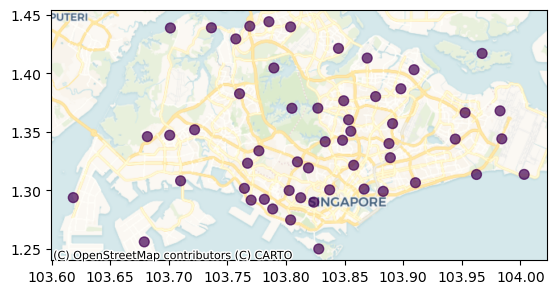

In [29]:
# node_df.plot(column='values')
fig, ax = plt.subplots(1,1)
ax = visualise_gauge_grid(node_df=node_df, ax=ax)

In [ ]:
print(test_row[-4:])

input = test_row[-4:]

fig, ax = plt.subplots(1,1, figsize=(12,8))


bounds_singapore = {
  'left': 103.6,
  'right': 104.05,
  'top': 1.5,
  'bottom': 1.15
}

size = visualise_radar_grid(input, ax=ax, zoom=bounds_singapore, scaling=None)


visualise_gauge_grid(node_df=gauge_df, ax=ax)
print(size)



In [ ]:
cml_data = load_cml_dataset('CML_data_processed_2025.nc')

In [ ]:
#Testing datetime function for merging

In [ ]:


# from datetime import datetime 

# t1 = '2025-02-05T04:30:00+08:00'
# t2 = '202502050430'

# x1 = datetime.fromisoformat(t1)
# x2 = datetime.strptime(t2, '%Y%m%d%H%M')
# x3 = datetime.strptime(t1, '%Y-%m-%dT%H:%M:00+08:00')

# print(x1)
# print(x2)
# print(x3)
# print(x2 == x3)

In [ ]:
rg = load_raingauge_dataset('station_locations_old.csv')

In [ ]:
station_dict = get_gauge_station_locations()
print(station_dict)

print(gauge_df)